# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/"

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train'  #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
import os
os.mkdir('/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/train')

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/train')

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')

In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
#Getting the image list 

imagelist  = os.listdir(path_train+'/train/images')
masklist = os.listdir(path_train+'/train/masks')

In [0]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7cc53fe88b.png
7cc53fe88b.png
de08c5a3b7.png
de08c5a3b7.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import cv2

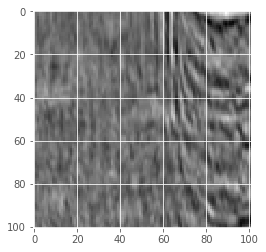

In [0]:
plt.imshow(cv2.imread(path_train+'/train/images/7cc53fe88b.png'))

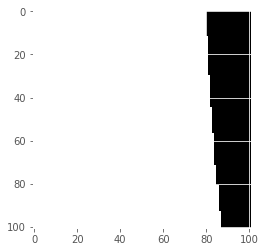

In [0]:
plt.imshow(cv2.imread(path_train+'/train/masks/7cc53fe88b.png'))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
# Get and resize train images and masks
from PIL import Image
import numpy as np
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path = os.path.join(path_train+'/train/images/', n)
        ##Add mask_path
        file = masklist[k]
        mask_path = os.path.join(path_train+'/train/masks/', file)                                                           
        
        # Load images and resize to (128,128,1)
        img = Image.open(image_path)
        resized_img = img.resize((im_width, im_height))
        resized_img = np.reshape(resized_img.convert('L'), (128,128,1)) ## Converting the image to greyscale # Minimizing the parameters
        
        
        # Load masks and resize to (128,128,1)
        mask = Image.open(mask_path)
        resized_mask = mask.resize((im_width, im_height))
        resized_mask = np.reshape(resized_mask.convert('L'), (128,128,1)) ## Converting the image to greyscale # Minimizing the parameters
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    #if train:
    return X, y
    #else:
    #    return X
    
X, y = get_data()

Done!


In [0]:
#Check the data
print(X.shape)
print(y.shape)

(4000, 128, 128, 1)
(4000, 128, 128, 1)


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

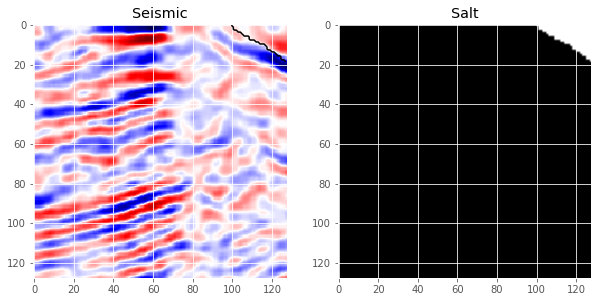

In [0]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### 8. Define loss and dice_coeff function.

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.


In [0]:
#Install segmentation models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-k3dl3y57
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-k3dl3y57
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-bgrpeiyw/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8


In [0]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

In [0]:
x_val.shape

(600, 128, 128, 1)

In [0]:
x_train.shape

(3400, 128, 128, 1)

In [0]:
y_train.shape

(3400, 128, 128, 1)

In [0]:
y_valid.shape

(600, 128, 128, 1)

In [0]:
#Build your model 
from keras.layers import Reshape
N = x_train.shape[-1]

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(128, 128, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
#x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(out)
#x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
#x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
#x = Reshape((im_height, im_width))(x)

model = Model(inp, out, name=base_model.name)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 3)       6         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________


In [0]:
#Get the summary of your model


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 3)       6         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________


In [0]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# compile model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [0]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=1,
    validation_data=(x_val, y_valid)
)

Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 55s 16ms/step - loss: 0.8624 - dice_coefficient: 0.6237 - val_loss: 1.9393 - val_dice_coefficient: 0.3602


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
model.evaluate(x_val, y_valid, verbose=1)

600/600 [==============================] - 3s 6ms/step


[1.947978728612264, 0.3599412161111832]

In [0]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)

600/600 [==============================] - 2s 3ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

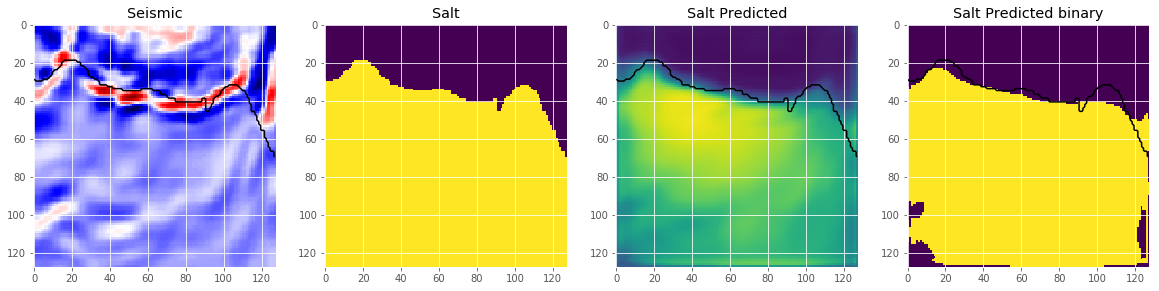

In [0]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Import Keras and other libraries

In [0]:
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(42)

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
project_path = "/gdrive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/"
import os
os.mkdir('/gdrive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/data')
os.chdir('/gdrive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/data')

#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'data.zip', 'r') as zf:
  zf.extractall()

In [0]:
#Getting the image list 
import os
project_path = "/gdrive/My Drive/Colab Notebooks/Advanced Computer Vision/Lab/"
filenames  = os.listdir(project_path+'/data/data/')

In [0]:
filenames

['For Love of the King.txt',
 'Salomé A tragedy in one act.txt',
 'Impressions of America.txt',
 'The Canterville Ghost.txt',
 'A House of Pomegranates.txt',
 'Miscellaneous Aphorisms_ The Soul of Man.txt',
 'A Woman of No Importance a play.txt',
 'Essays and Lectures.txt',
 'The Happy Prince and other tales.txt',
 'Rose Leaf and Apple Leaf.txt',
 'Vera or, The Nihilists.txt',
 'Lord Arthur Savile_s Crime.txt',
 'Poems with the Ballad of Reading Gaol.txt',
 'Selected poems of oscar wilde including The Ballad of Reading Gaol.txt',
 'Charmides and Other Poems.txt',
 'An Ideal Husband.txt',
 'The Duchess of Padua.txt',
 'Oscar Wilde Miscellaneous.txt',
 'The Ballad of Reading Gaol.txt',
 'Shorter Prose Pieces.txt',
 'Children in Prison and Other Cruelties of Prison Life.txt',
 'Reviews.txt',
 'A Critic in Pall Mall.txt',
 'De Profundis.txt',
 'Miscellanies.txt',
 'The Importance of Being Earnest.txt',
 'Selected prose of oscar wilde with a Preface by Robert Ross.txt',
 'The Soul of Man.t

In [0]:
# Considering only a couple of files as the system is getting crashed with the complete data
filenames = filenames[0:2]

In [0]:
filenames

['For Love of the King.txt', 'Salomé A tragedy in one act.txt']

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
book_text=[]
for file in filenames:
  doc_text = open(project_path+'/data/data/'+file, encoding='utf8').read() #reading the book as a string
  book_text.append(doc_text)
  words=doc_text.split()
  print('Length of the document '+file+' in words:' , len(words))
print('No. of Documents in the book: ' , len(book_text))

Length of the document For Love of the King.txt in words: 7015
Length of the document Salomé A tragedy in one act.txt in words: 16218
No. of Documents in the book:  2


## Process the text
Initialize and fit the tokenizer

In [0]:
#Tokenize at word level
#t = tf.keras.preprocessing.text.text_to_word_sequence(text=book_text[0],lower=False)

#Fit tokenizer on the book
#t.fit_on_texts(book_text)

#Vocablury size
#vocab_size = len(set(t))

#print('Number of unique words: ', vocab_size)

In [0]:
#Tokenize at word level
t = tf.keras.preprocessing.text.Tokenizer()

#Fit tokenizer on the book
t.fit_on_texts(book_text)

#Vocablury size
vocab_size = len(t.word_index)

print('Number of unique words: ', vocab_size)

Number of unique words:  3260


In [0]:
print(t.word_counts)
print(t.document_count)
print(t.word_docs)

OrderedDict([('\ufeffthe', 2), ('project', 173), ('gutenberg', 193), ('ebook', 21), ('for', 155), ('love', 18), ('of', 851), ('the', 1474), ('king', 51), ('by', 95), ('oscar', 14), ('wilde', 22), ('this', 166), ('is', 448), ('use', 26), ('anyone', 10), ('anywhere', 4), ('at', 147), ('no', 89), ('cost', 6), ('and', 465), ('with', 216), ('almost', 6), ('restrictions', 4), ('whatsoever', 10), ('you', 364), ('may', 56), ('copy', 24), ('it', 292), ('give', 39), ('away', 11), ('or', 167), ('re', 4), ('under', 18), ('terms', 42), ('license', 32), ('included', 6), ('online', 8), ('www', 22), ('org', 26), ('title', 7), ('a', 486), ('burmese', 15), ('masque', 4), ('author', 5), ('release', 2), ('date', 6), ('october', 1), ('28', 1), ('2007', 1), ('23229', 4), ('language', 5), ('english', 10), ('character', 2), ('set', 24), ('encoding', 1), ('iso', 1), ('646', 1), ('us', 22), ('ascii', 5), ('start', 7), ('transcribed', 1), ('from', 86), ('1922', 2), ('methuen', 3), ('co', 3), ('jarrold', 1), ('so

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
#Build a dictionary which can convert numbers into words
int_to_word = dict((i,c) for c, i in t.word_index.items())

In [0]:
int_to_word[115]

'only'

Get the word count for every word and also get the total number of words.

In [0]:
print(t.word_counts)
print(len(t.word_index))

OrderedDict([('\ufeffthe', 2), ('project', 173), ('gutenberg', 193), ('ebook', 21), ('for', 155), ('love', 18), ('of', 851), ('the', 1474), ('king', 51), ('by', 95), ('oscar', 14), ('wilde', 22), ('this', 166), ('is', 448), ('use', 26), ('anyone', 10), ('anywhere', 4), ('at', 147), ('no', 89), ('cost', 6), ('and', 465), ('with', 216), ('almost', 6), ('restrictions', 4), ('whatsoever', 10), ('you', 364), ('may', 56), ('copy', 24), ('it', 292), ('give', 39), ('away', 11), ('or', 167), ('re', 4), ('under', 18), ('terms', 42), ('license', 32), ('included', 6), ('online', 8), ('www', 22), ('org', 26), ('title', 7), ('a', 486), ('burmese', 15), ('masque', 4), ('author', 5), ('release', 2), ('date', 6), ('october', 1), ('28', 1), ('2007', 1), ('23229', 4), ('language', 5), ('english', 10), ('character', 2), ('set', 24), ('encoding', 1), ('iso', 1), ('646', 1), ('us', 22), ('ascii', 5), ('start', 7), ('transcribed', 1), ('from', 86), ('1922', 2), ('methuen', 3), ('co', 3), ('jarrold', 1), ('so

Convert text to sequence of numbers

In [0]:
#Convert words in the book to Numbers
book_num = t.texts_to_sequences(book_text)

In [0]:
len(book_num[0])

7255

### Generate Features and Labels

In [0]:
record_num = 0 #starting batch number
sequence_length = 100 #Length of input sequence

def batch_generator(batch_size=32):
    
    #Will update batch_num
    global record_num    
    
    while True:
        
        #Empty list for input and output data
        input_data = []
        output_data = []

        for j in range(len(book_num)):
          
          for i in range(batch_size//len(book_num)):
          
            #print(i)
            #print(j)
            #print(record_num*sequence_length + sequence_length)
            #print(j)
            #print(len(book_num[j]))
            #input sequence
            input_seq = book_num[j][(record_num * sequence_length) : (record_num * sequence_length) + sequence_length]
            #Output sequence
            #print(j)
            output_seq = book_num[j][(record_num * sequence_length) + sequence_length]

            input_data.append(input_seq)
            output_data.append(output_seq)
            
            record_num = record_num + 1
            
            #print(record_num)
            
            
            if((record_num*sequence_length + sequence_length) > len(book_num[j])):
                record_num = 0
          record_num = 0      

        #Input data one hot encoding
        input_data_one_hot = tf.keras.utils.to_categorical(input_data,num_classes=vocab_size+1)

        #Output data one hot encoding
        output_data = tf.keras.utils.to_categorical(output_data,num_classes=vocab_size+1)

        #Reshape input data into 3 dimensional numpy array
        #batch_size x sequence_length x vocab_size+1
        input_data_one_hot = np.reshape(input_data_one_hot,
                                (len(input_data_one_hot),
                                 sequence_length,
                                 vocab_size+1))
        
        yield input_data_one_hot, output_data

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
#Identify a random sequence which we will use to generate output
doc_num =   np.random.randint(0, len(book_num))
start_pos = np.random.randint(0, high=(len(book_num[doc_num]) - sequence_length))
test_seq =  book_num[doc_num][start_pos : start_pos+sequence_length]

In [0]:
#Print random starting sequence for prediction
print('Initial sequence is: ')
for i in range (sequence_length):
    print(int_to_word[int(test_seq[i])], end='')

Initial sequence is: 
notwishanyonetospeakwithhimhehasevenforbiddenthehighpriesttospeakwithhimsaloméidesiretospeakwithhimfirstsoldieritisimpossibleprincesssaloméiwillspeakwithhimtheyoungsyrianwoulditnotbebettertoreturntothebanquetsalomébringforththisprophetexittheslavefirstsoldierwedarenotprincesssaloméapproachingthecisternandlookingdownintoithowblackitisdownthereitmustbeterribletobeinsoblackapititislikeatombtothesoldiersdid

This is just to check the features and labels

In [0]:
def predict_seq(epoch, logs):
    
    print('Output sequence is: ')
    
    #Initialize predicted output
    predicted_output = ''
    
    #lets predict 50 next chars
    current_seq = np.copy(test_seq)
    for i in range(50):
        current_seq_one_hot = tf.keras.utils.to_categorical(current_seq, num_classes=vocab_size+1)
        data_input = np.reshape(current_seq_one_hot,(1,
                                                     current_seq_one_hot.shape[0],
                                                     current_seq_one_hot.shape[1]))
        
        #Get the char int with maximum probability
        predicted_char_int = np.argmax(model.predict(data_input)[0])
        
        if (predicted_char_int != 0):
          
          #Add to the predicted out, convert int to char
          predicted_output = predicted_output + int_to_word[predicted_char_int]
          
        #Update seq with new value at the end
        current_seq = np.roll(current_seq, -1)
        current_seq[current_seq.shape[0]-1] = predicted_char_int
    
    print(predicted_output)

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(sequence_length,vocab_size+1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(vocab_size+1, activation='softmax'))

W0625 08:22:31.516932 140095109158784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy') #No accuracy tracking here

### Save Model

In [0]:
model.save("word_rnn.h5")

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
import tensorflow as tf
model = tf.keras.models.load_model('word_rnn.h5')

W0625 08:22:50.292219 140095109158784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 08:22:50.294638 140095109158784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 08:22:50.296645 140095109158784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [0]:
#Create a LabdaCallback to do prediction at end of every epoch
lambda_checkpoint = tf.keras.callbacks.LambdaCallback(on_epoch_end=predict_seq)

#Create a model checkpoint to store model after each epoch if loss reduces
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('word_rnn.h5',
                                                      monitor='loss',
                                                      save_best_only=True)

In [0]:
batch_size = 2
train_generator = batch_generator(batch_size=batch_size)

#Fit generator
model.fit_generator(train_generator,
                    epochs=1,
                    steps_per_epoch = (len(book_num[doc_num])- sequence_length)// batch_size,                    
                    callbacks=[model_checkpoint, lambda_checkpoint])

W0625 08:23:07.606082 140095109158784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


8151/8152 [============================>.] - ETA: 0s - loss: 0.0745Output sequence is: 
fromfromfromfromfrommademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademademade
8152/8152 [==============================] - 2375s 291ms/step - loss: 0.0744


## Evaluation

In [0]:
model.evaluate_generator(train_generator,steps= (len(book_num[doc_num])- sequence_length)// batch_size)

0.0001142992261415384

## Generate text

In [0]:
predicted_char_int = np.argmax(model.predict_generator(train_generator,steps= (len(book_num[doc_num])- sequence_length)// batch_size)[0])

In [0]:
int_to_word[predicted_char_int]

'from'